# Qiskit v2.0 — Ep. 10: Measuring Qubits

This episode covers how to measure quantum states in Qiskit v2.0, collapse them into classical information, and visualize results. We also explore advanced measurement patterns including conditional execution based on measurement outcomes.

## 🎯 Learning goals

- Understand the concept of measurement in Qiskit and its implications on quantum states.
- Perform single, full, and *active* qubit measurements.
- Use the `Measure` class as a standalone instruction.
- Apply conditional execution with `if_test()` and `if_else()`.
- Visualize measurement results with histograms.

## 1) Concept of measurement in Qiskit (v2.0)

In Qiskit, measurement is an explicit instruction that **maps qubits to classical bits**. When executed on a backend, a *readout* collapses each measured qubit to `0` or `1`, storing the result in a classical register. On real hardware measurement is destructive: the quantum state is not preserved after readout.

> **Bit ordering reminder (little‑endian):** the rightmost bit in a bitstring corresponds to **qubit 0**.

In [1]:
# Imports used across the episode
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Measure, Parameter
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import pi

backend = AerSimulator()

## 2) Single measurement (fine‑grained mapping)
Map a specific **qubit → classical bit** with `qc.measure(q, c)`.

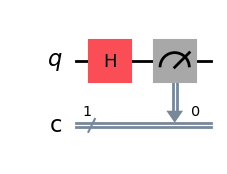

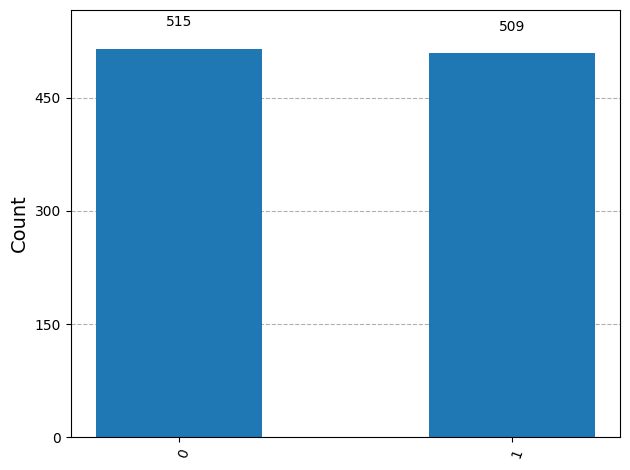

In [4]:
qc = QuantumCircuit(1, 1)  # 1 qubit, 1 clbit
qc.h(0)
qc.measure(0, 0)
display(qc.draw('mpl'))

tqc = transpile(qc, backend)
result = backend.run(tqc, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

## 3) The `Measure` class as an instruction
You can add a measurement as a standalone instruction object. This is helpful when **programmatically building** or **appending** to subcircuits.

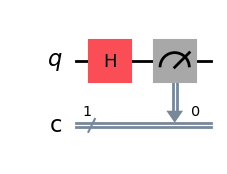

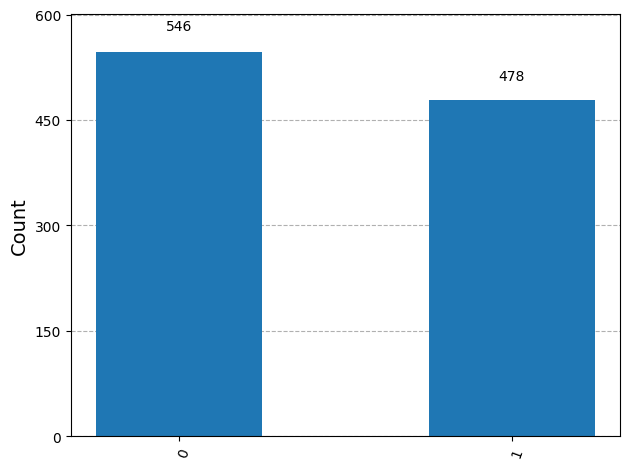

In [5]:
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.append(Measure(), [0], [0])  # qubits=[0], clbits=[0]
display(qc.draw('mpl'))

tqc = transpile(qc, backend)
counts = backend.run(tqc, shots=1024).result().get_counts()
plot_histogram(counts)

## 4) Measuring all qubits with `measure_all()`
`measure_all()` automatically **adds classical bits** (one per qubit) and measures every qubit. Great for full readout at the end of a circuit.

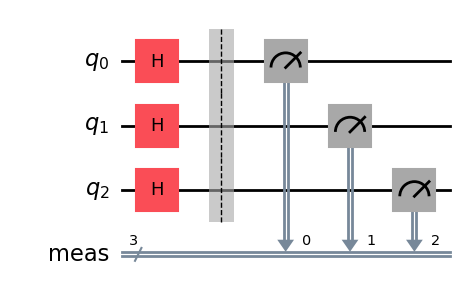

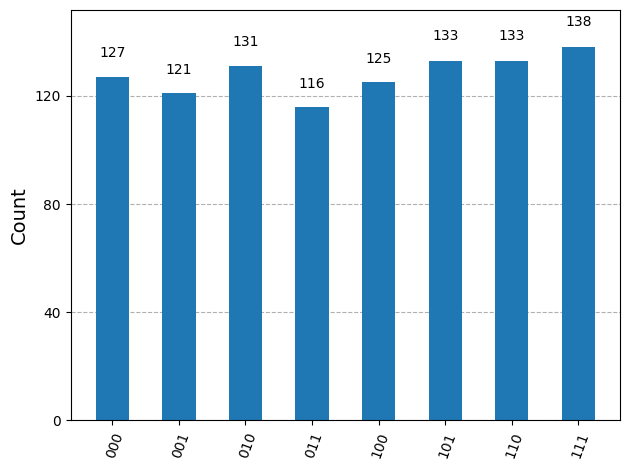

In [6]:
qc = QuantumCircuit(3)  # no classical bits yet
qc.h([0, 1, 2])
qc.measure_all()
display(qc.draw('mpl'))

tqc = transpile(qc, backend)
counts = backend.run(tqc, shots=1024).result().get_counts()
plot_histogram(counts)

## 5) Measuring only *active* qubits with `measure_active()`
`measure_active()` measures only those qubits that had **operations applied** (non‑idle), which can save classical storage.

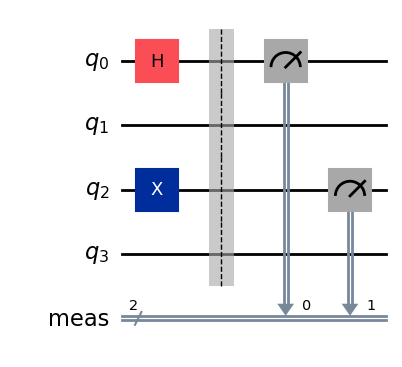

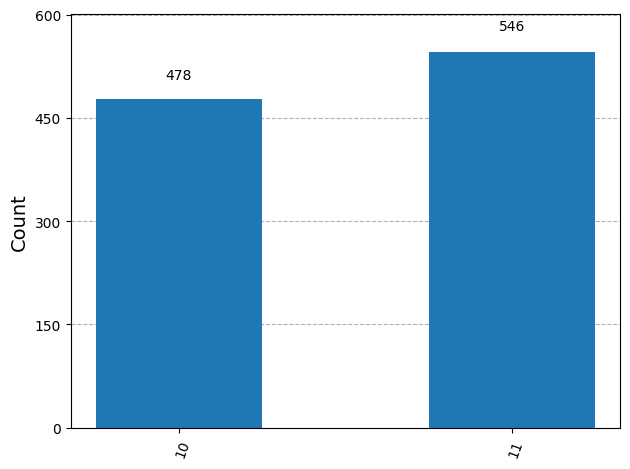

In [7]:
qc = QuantumCircuit(4)  # 4 qubits, no classical bits yet
qc.h(0)
qc.x(2)
qc.measure_active()
display(qc.draw('mpl'))

tqc = transpile(qc, backend)
counts = backend.run(tqc, shots=1024).result().get_counts()
plot_histogram(counts)

## 6) Conditional execution based on measurement
Qiskit v2.0 provides classical control with **`if_else()`** and the **`if_test()` context**.
- `if_else(condition, true_body, false_body, ...)` embeds subcircuits selected by a classical condition.
- `with qc.if_test(condition) as else_:` is a readable context for true/optional false branches.

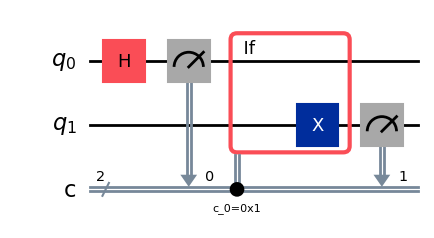

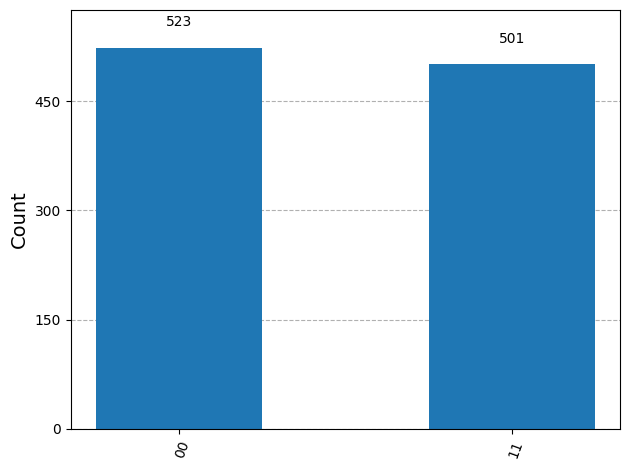

In [8]:
# Example with if_else(): If c[0] == 1, apply X to qubit 1
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.measure(0, 0)

# true branch subcircuit
true_body = QuantumCircuit(2, 2)
true_body.x(1)

qc.if_else((qc.clbits[0], 1), true_body, None, [0,1], [0,1])
qc.measure(1, 1)
display(qc.draw('mpl'))

tqc = transpile(qc, backend)
counts = backend.run(tqc, shots=1024).result().get_counts()
plot_histogram(counts)

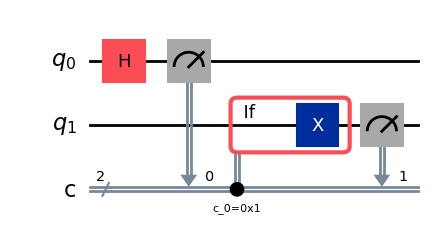

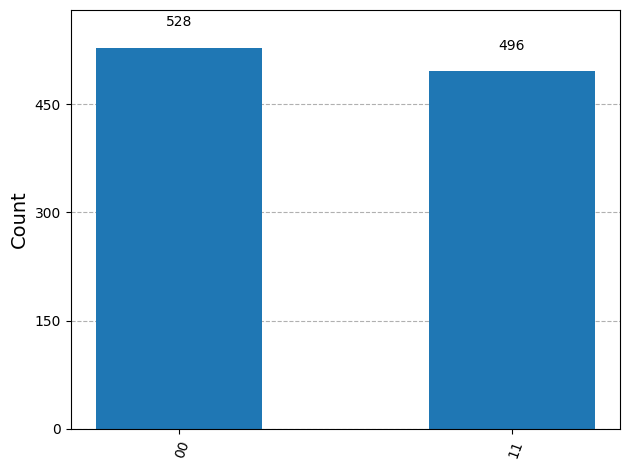

In [9]:
# Example with if_test(): same logic using a context manager
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.measure(0, 0)

with qc.if_test((qc.clbits[0], 1)) as else_:
    qc.x(1)
# else_ branch is optional; we skip it here

qc.measure(1, 1)
display(qc.draw('mpl'))

tqc = transpile(qc, backend)
counts = backend.run(tqc, shots=1024).result().get_counts()
plot_histogram(counts)

## 7) Visualizing results
We typically **transpile to the simulator’s basis gates** and then run to obtain `counts`, which are displayed with `plot_histogram()`.

## 8) Random circuits + full readout
Sometimes it’s useful to generate a random circuit and study its measurement distribution.

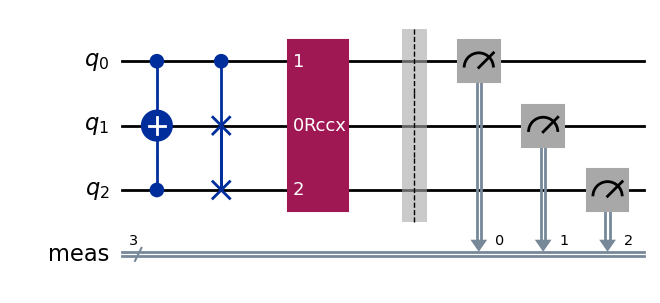

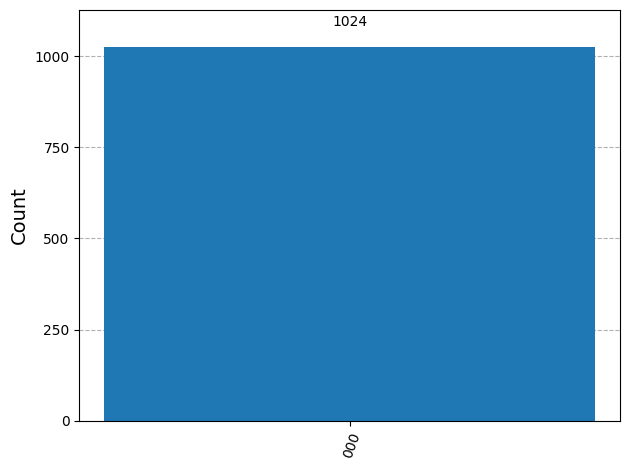

In [10]:
from qiskit.circuit.random import random_circuit

rc = random_circuit(num_qubits=3, depth=3, measure=False, seed=42)
rc.measure_all()
display(rc.draw('mpl'))

tqc = transpile(rc, backend)
counts = backend.run(tqc, shots=1024).result().get_counts()
plot_histogram(counts)

## 9) Mini‑Challenge
**Task.** Build a 2‑qubit circuit that measures `q0` into `c0`. If `c0==1`, apply `Z` to `q1`; otherwise do nothing. Measure `q1` to `c1` and plot the result. Try both `if_else()` **and** `if_test()`.

<details>
<summary><strong>Solution</strong></summary>

```python
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

sim = AerSimulator()
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.measure(0, 0)

true_body = QuantumCircuit(2, 2)
true_body.z(1)
qc.if_else((qc.clbits[0], 1), true_body, None, [0,1], [0,1])
qc.measure(1, 1)

display(qc.draw('mpl'))
counts = sim.run(transpile(qc, sim), shots=1024).result().get_counts()
plot_histogram(counts)
```
</details>

## Additional information

**Created by:** Ricard Santiago Raigada García

**Version:** 1.0.0